In [1]:
###### import
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
from scipy import signal
from importlib import reload

import winsound as sd
import pickle
import sys
import os

from Tools.tools import *
from Plasticity.plasticity import *
from Neuron.neuron import *
from Model.model import *
from Analysis.analysis import *
import Operate_model

In [2]:
class config:
    def __init__(self, pc):
        # The number of neurons
        self.N_I = 16
        self.N_O = self.N_I

        self.N_DG = 800
        self.N_DGH = self.N_I
        self.N_DGM = 100 
        self.N_DGB = 400 

        self.N_CA3 = pc[3] 
        self.N_CA1 = 200
        self.N_CA3i = pc[4] 
        
        # Weights of each connection
        # From EC
        self.w_EI = 3
        self.w_ppDG = 2 
        self.w_ppCA3 = 1 
        self.w_ppCA1 = 0.5 

        # DG
        self.w_IH = 3 
        self.w_IB = 4 
        self.w_IM = 3 
        self.w_HM = 4 
        self.w_MB = 4 
        self.w_BDG = 3 

        # CA3
        self.w_mf = 2 
        self.w_mfi = 2 
        self.w_Rc = 1

        self.w_CA33i = 1
        self.w_3iCA3 = 2 
        self.w_3i3i = 0.5 
        self.w_NoCA3 = 0.5

        # CA1
        self.w_Sc = 0.15
        self.w_CA1O = 2 

        # The number of connections 
        # From EC
        self.c_ppDG = 1
        self.c_ppCA3 = 8
        self.c_ppCA1 = 3

        # DG
        self.c_IH = 1
        self.c_IB = self.N_I
        self.c_IM = self.N_I*2//3
        self.c_HM = 1
        self.c_MB = self.N_I
        self.c_BDG = 1

        # CA3
        self.c_mf = pc[0]
        self.c_mfi = pc[1]
        self.c_Rc = self.N_CA3//4

        self.c_CA33i = self.N_CA3i//4
        self.c_3iCA3 = pc[2]
        self.c_3i3i = pc[5]
        self.c_NoCA3 = self.N_CA3
        self.c_Sc =  self.N_CA3//2

        # Parameters for delay
        self.d_I = 10
        self.d_O = 15
        self.d_DG = 3
        self.d_CA3 = 5
        self.d_CA3i = 1

In [3]:
# init
pc = [30,3,600,2400,120,20]
already_learned = False
learned_weights = [0,0,0,0]
params = config(pc)

In [4]:
# Generation data
np.random.seed(100)
Datalen = 1250
Data = np.zeros((params.N_I,Datalen))
for n in range(Datalen):
    num_F = np.random.randint(params.N_I)+1
    Data[:,n] = generate_binvec(params.N_I, num_F) 

In [5]:
# Delete repetitive data
Data_set = []
for n in range(Datalen):
    Data_set.append(set(np.where(Data[:,n] !=0)[0]))
Repeated_data = []
for i, comp in enumerate(Data_set):
    for j, comp2 in enumerate(Data_set):
        if i < j:
            if comp == comp2:
                Repeated_data.append(j)
                
Data_final_idx = set(range(Datalen))-set(Repeated_data)
Datalen_final = len(Data_final_idx)
Data_final = np.zeros((params.N_I,Datalen_final))
for i, comp in enumerate(Data_final_idx):
    Data_final[:,i] = Data[:,comp]
print(Datalen_final)

997


In [6]:
a

NameError: name 'a' is not defined

In [7]:
# DG separation 
# initiation
Freq = 20
En_win = 120
Re_win = 0

ER = True
theta = False
only_DG = True
only_CA3 = False

In [13]:
# Observe the granule cell patterns for each data
params = config(pc)
network = SNN(params, Neuron, Synapse, learned_weights, already_learned)

DG_FR = np.zeros((params.N_DG, Datalen_final))
DG_FR_temp = np.zeros(params.N_DG)
input_total = set(range(params.N_I))
output_total = set(range(params.N_DG))

for D in range(Datalen_final):
    for T in range(En_win):
        env = np.zeros(params.N_I)
        if T % Freq == 0 and T <= En_win-40:
            env = Data_final[:,D]
        Noise = np.random.poisson(0.000, params.N_CA3)
        CA3input = 0

        network.solve(env, CA3input, Noise, ER, theta, T, only_DG, only_CA3, En_win, Re_win)
        DG_FR_temp = prepare_data_FR(DG_FR_temp, params.N_DG, network.layers[5])

    DG_FR[:,D] = DG_FR_temp.copy()
    DG_FR_temp = np.zeros(params.N_DG)

# The length of granule cell patterns
DGlen_list = np.array([])
for d in range(Datalen_final):
    DGlen_list = np.append(DGlen_list, len(list(np.where(DG_FR[:,d] !=0)[0])))

# Calculation the pattern separation by overlap degree
OverI = np.array([])
OverO = np.array([])
Pair_idx = []
for i in range(Datalen_final):
    for j in range(Datalen_final):
        if i < j:
            input_A = set(np.where(Data_final[:,i] !=0)[0])
            input_B = set(np.where(Data_final[:,j] !=0)[0])
            if input_A != input_B:
                output_A = set(np.where(DG_FR[:,i] !=0)[0])
                output_B = set(np.where(DG_FR[:,j] !=0)[0])
                if len(output_A)+len(output_B) != 0:
                    overlap_input = cal_overlap(input_total, input_A, input_B)
                    overlap_output = cal_overlap(output_total, output_A, output_B)
                    OverI = np.append(OverI, overlap_input)
                    OverO = np.append(OverO, overlap_output)
                    Pair_idx.append([i,j])

KeyboardInterrupt: 

In [ ]:
SP = (np.mean(OverI)-np.mean(OverO))/np.mean(OverI)
x = np.linspace(0,1,100)
print('Separation power : ', SP)
plt.scatter(OverI, OverO, color='cornflowerblue')
plt.plot(x,x, color='black')
plt.xlim([0,1])
plt.ylim([0,1.2])
plt.xlabel('Input overlap')
plt.ylabel('Output overlap')
plt.show()
            
print('Mean and std of the output size : ', np.mean(DGlen_list), np.std(DGlen_list))
print('The number of nonfiring input : ', len(np.where(DGlen_list == 0)[0]))
plt.scatter(range(len(DGlen_list)), DGlen_list, color='cornflowerblue')
plt.xlabel('Output index')
plt.ylabel('The number of firing granule cell')
plt.show()
            
DGlen_idx, DGlen_idx_excluded = engram_filter(5, Datalen_final, DGlen_list)
OverI_v2, OverO_v2, Pair_idx_v2 = filter_SP(OverI, OverO, Pair_idx, DGlen_idx_excluded)
            
SP_v2 = (np.mean(OverI_v2)-np.mean(OverO_v2))/np.mean(OverI_v2)
print('Separation Power : ', SP_v2)
plt.scatter(OverI_v2, OverO_v2, color='cornflowerblue')
plt.plot(x,x, color='black')
plt.xlim([0,1])
plt.ylim([0,1.2])
plt.xlabel('Input Overlap')
plt.ylabel('Output Overlap')
plt.show()
            
print('Mean and Std of the Output Size : ', np.mean(DGlen_list[DGlen_idx]), np.std(DGlen_list[DGlen_idx]))
print('The Number of Nonfiring Input : ', len(np.where(DGlen_list[DGlen_idx] == 0)[0]))
print('Filtered Input Number : ', len(DGlen_list[DGlen_idx]))
plt.scatter(range(len(DGlen_list[DGlen_idx])), DGlen_list[DGlen_idx], color='cornflowerblue')
plt.ylim([0,5])
plt.xlabel('Output Index')
plt.ylabel('The Number of Firing Granule Cell')
plt.show()

sns.histplot(OverI_v2, binwidth= 0.05, kde=True, color='cornflowerblue')
sns.histplot(OverO_v2, binwidth= 0.05, kde=True, color='salmon')
plt.title('Histogram of Overlap')
plt.xlabel('Overlap')
plt.ylabel('Count')
plt.legend(['Input', 'Output'])
plt.show()

sns.histplot(DGlen_list, binwidth= 0.5, kde=True, color='cornflowerblue')
plt.title('Histogram of Output size')
plt.xlabel('Output size')
plt.ylabel('Count')
plt.show()

In [15]:
with open('Data_DG.pkl', 'wb') as file:
    pickle.dump(Data, file)
    pickle.dump(Datalen, file)
    pickle.dump(DG_FR, file)
    
    pickle.dump(DGlen_list, file)
    pickle.dump(DGlen_idx, file)
    pickle.dump(DGlen_idx_excluded, file)

    pickle.dump(OverI, file)
    pickle.dump(OverO, file)
    pickle.dump(Pair_idx, file)  
    
    pickle.dump(OverI_v2, file)
    pickle.dump(OverO_v2, file)
    pickle.dump(Pair_idx_v2, file)  

NameError: name 'DG_FR' is not defined

mf / mfi / 3i ca3 / ca3 / ca3i :  [30, 3, 600, 2400, 120, 20]
Separation Power :  0.5011661329219187


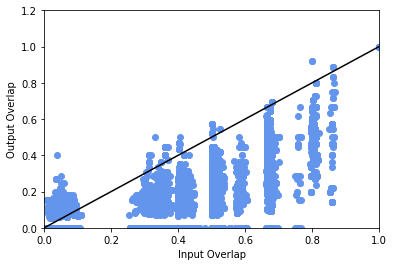

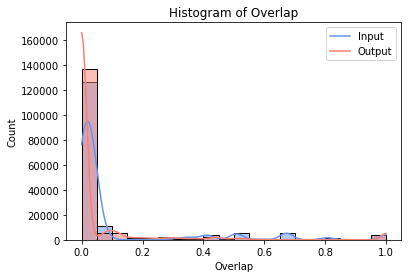

mean and std of the output size :  10.40630472854641 3.936389418165934
the number of nonfiring input :  0


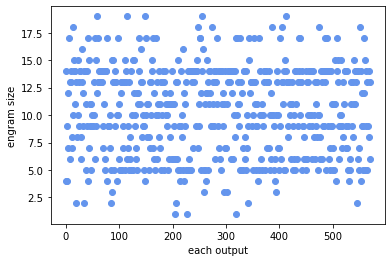

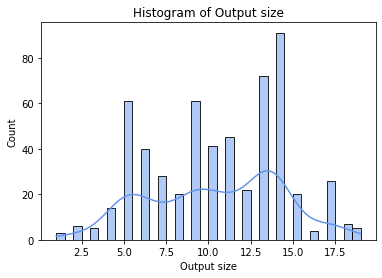

Inhibition degree of other engrams :  0.7107342754784822 0.2679214006720616
-------------------------------------
Inhibition degree of other engrams(inh) :  0.02080156520012728 0.06904650550933854
-------------------------------------
Mean overlap :  0.05619303162253667


In [22]:
# Prediction the CA3 neural assemblies based on the connectivity
Gra_idx = []
for i, comp in enumerate(DGlen_idx):
    Gra_idx.append(set(np.where(DG_FR[:,comp] !=0)[0]))
                   
SP3_List = []
F_N = 3
params = config(pc)
F_DataLen = len(Gra_idx)
network = SNN(params, Neuron, Synapse, learned_weights, already_learned)
input_total = set(range(params.N_CA3))
output_total = set(range(params.N_CA3))
Bf_py = []
Bf_in = []
Af_py = []
Af_in = []
In_py_list = []
In_in_list = []

for n, dgtn in enumerate(Gra_idx):
    # Pyramidal neurons stimulated by each granule cell
    Bf_py_temp = set()
    for m, comp in enumerate(dgtn):
        Bf_py_temp |= set(np.where(network.q_mf[comp,:] != 0)[0])
    Bf_py.append(Bf_py_temp)

    # Inhibitory neurons stimulated by each granule cell
    Bf_in_temp = set()
    for mi, compi in enumerate(dgtn):
        Bf_in_temp |= set(np.where(network.q_mfi[compi,:] != 0)[0])
    Bf_in.append(Bf_in)

    # Effects of firing inhibitory neurons
    In_in = []
    for n, bas in enumerate(Bf_in_temp):
        In_in = np.append(In_in, np.where(network.q_3i3i[bas,:] !=0)[0])
    In_in_list.append(In_in)
    # Filtered inhibitory neurons by F_N inhibitory neurons
    Af_in_temp = []
    for i, bas in enumerate(Bf_in_temp):
        if 0 <= len(np.where(In_in == bas)[0]) <= F_N:
            Af_in_temp.append(bas)
    Af_in.append(Af_in_temp)
    # Final effects of firing inhibitory neurons
    In_py = []
    for m, bas in enumerate(Af_in_temp):
        In_py = np.append(In_py, np.where(network.q_3iCA3[bas,:] !=0)[0])
    In_py_list.append(In_py)
    # Filtered excitatory neurons by inhibition
    Af_py_temp = []
    for i, pyra in enumerate(Bf_py_temp):
        if pyra not in In_py:
            Af_py_temp.append(pyra)
    Af_py.append(Af_py_temp)

CA3len_list = np.array([])

for d in range(F_DataLen):
    CA3len_list = np.append(CA3len_list, len(Af_py[d]))

OverI_CA3 = np.array([])
OverO_CA3 = np.array([])
Pair_idx_CA3 = []
for i in range(F_DataLen):
    for j in range(F_DataLen):
        if i < j:
            input_A = set(Bf_py[i])
            input_B = set(Bf_py[j])
            output_A = set(Af_py[i])
            output_B = set(Af_py[j])

            if len(output_A)+len(output_B) != 0:
                overlap_input = cal_overlap(input_total, input_A, input_B)
                overlap_output = cal_overlap(output_total, output_A, output_B)
                OverI_CA3 = np.append(OverI_CA3, overlap_input)
                OverO_CA3 = np.append(OverO_CA3, overlap_output)
                Pair_idx_CA3.append([i,j])


Score_list = []
for i, bas in enumerate(In_py_list):
    for j, pyra in enumerate(Af_py):
        if len(pyra) != 0:
            if i != j:
                score = 0
                for k, p in enumerate(pyra):
                    if p in bas:
                        score += 1
                score = score/len(pyra)
                Score_list.append(score)
Score_list_in = []
for i, bas in enumerate(In_in_list):
    for j, bas2 in enumerate(Af_in):
        if len(bas2) != 0:
            if i != j:
                score = 0
                for k, b in enumerate(bas2):
                    if F_N < len(np.where(bas == b)[0]):
                        score += 1
                score = score/len(bas2)
                Score_list_in.append(score)

print('mf / mfi / 3i ca3 / ca3 / ca3i : ', pc)
SP_CA3 = (np.mean(OverI_CA3)-np.mean(OverO_CA3))/np.mean(OverI_CA3)
print('Separation Power : ', SP_CA3)   

x = np.linspace(0,1,100)
plt.scatter(OverI_CA3, OverO_CA3, color='cornflowerblue')
plt.plot(x,x, color='black')
plt.xlim([0,1])
plt.ylim([0,1.2])
plt.xlabel('Input Overlap')
plt.ylabel('Output Overlap')
plt.show()

sns.histplot(OverI_CA3, binwidth= 0.05, kde=True, color='cornflowerblue')
sns.histplot(OverO_CA3, binwidth= 0.05, kde=True, color='salmon')
plt.title('Histogram of Overlap')
plt.xlabel('Overlap')
plt.ylabel('Count')
plt.legend(['Input', 'Output'])
plt.show()

print('mean and std of the output size : ', np.mean(CA3len_list), np.std(CA3len_list))
print('the number of nonfiring input : ', len(np.where(CA3len_list == 0)[0]))
plt.scatter(range(len(CA3len_list)), CA3len_list, color='cornflowerblue')
plt.xlabel('each output')
plt.ylabel('engram size')
plt.show()        

sns.histplot(CA3len_list, binwidth= 0.5, kde=True, color='cornflowerblue')
plt.title('Histogram of Output size')
plt.xlabel('Output size')
plt.ylabel('Count')
plt.show()    

print('Inhibition degree of other engrams : ', np.mean(Score_list), np.std(Score_list))
print('-------------------------------------')
print('Inhibition degree of other engrams(inh) : ', np.mean(Score_list_in), np.std(Score_list_in))
print('-------------------------------------')
print('Mean overlap : ', np.mean(OverO_CA3))
if np.mean(Score_list) >= 0.7 and np.mean(Score_list_in)  >= 0.7:
    print(parameter, np.mean(Score_list), np.mean(Score_list_in))

In [ ]:
# Filtered data (by granule cell engram size).
Filt_idata = Data[:,DGlen_idx]
# Filtered granule cells
Filt_gdata = DG_FR[:,DGlen_idx]
# Filtered granule cell engrams nubmer
Filt_glen = DGlen_list[DGlen_idx]
Filt_glen = list(map(int, Filt_glen))

In [ ]:
with open('Data_final.pkl', 'wb') as file:
    pickle.dump(Filt_idata, file)
    pickle.dump(Filt_gdata, file)
    pickle.dump(Filt_glen, file)

    pickle.dump(Af_py, file)
    pickle.dump(Af_in, file)
    
    pickle.dump(In_py_list, file)